In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta as td
import pandas as pd
%matplotlib inline
import sys

#Make sure Python Analysis folder in in PYTHONPATH and import the MHDpy module
PythonAnalysisPath = 'C:\\Users\\aspit\\Documents\\Git\\MHDLab\\Python Analysis'
if not PythonAnalysisPath in sys.path:
    sys.path.append(PythonAnalysisPath)
import MHDpy.importing
import MHDpy.plotting
import MHDpy.analysis
from nptdms import TdmsFile as TF

import importlib



mpl.rcParams.update({'font.size': 18})
    


In [2]:
###Paths###
pathnames_PL = MHDpy.importing.get_pathnames("C:\\Users\\aspit\\OneDrive\\Data\\2018-04-05 Power dependence\\Seqtry2", regExp= ".*\.tdms$")
pathnames_power = MHDpy.importing.get_pathnames("C:\\Users\\aspit\\OneDrive\\Data\\2018-04-05 Power dependence\\Powermeter\\Chosen\\50Hz", regExp= ".*\.tdms$")
pathnames_laser= MHDpy.importing.get_pathnames("C:\\Users\\aspit\\OneDrive\\Data\\2017-10-23")

###Files###

files_50Hz = pd.DataFrame(index = {'NDF00','NDF01','NDF02'}, columns = {'PL', 'Power'})

files_50Hz['PL']['NDF00'] = TF(pathnames_PL['Run15kV_Rb_NDF00_seq_50Hz_2000aq.tdms'])
files_50Hz['PL']['NDF01'] = TF(pathnames_PL['Run15kV_Rb_NDF01_seq_50Hz.tdms'])
files_50Hz['PL']['NDF02'] = TF(pathnames_PL['Run15kV_Rb_NDF02_seq_50Hz_7.tdms'])


files_50Hz['Power']['NDF00'] = TF(pathnames_power['Run15kV_Powermeter_NDF00_seq_50Hz_2000aq.tdms'])
files_50Hz['Power']['NDF01'] = TF(pathnames_power['Run15kV_Powermeter_NDF01_seq_50Hz.tdms'])
files_50Hz['Power']['NDF02'] = TF(pathnames_power['Run15kV_Powermeter_NDF02_seq_50Hz_7.tdms'])


file_laser = TF(pathnames_laser[0])

In [3]:
###Groups and Channels###

laser_common = file_laser.object('Raw').as_dataframe()
laser_data = file_laser.object('Average').as_dataframe()

laser_time = laser_common['Time1']
laser_data = laser_data['Mean']
laser_data_norm = laser_data/laser_data.max()

data_50Hz = pd.DataFrame(index = {'NDF00','NDF01','NDF02'},
                         columns = {'Data' , 'Time', 'Power','Power_avg','Data_p1_max', 'Data_p2_max', 'Data_p1_max_norm', 'Data_p2_max_norm'})




for index in files_50Hz.index:
    group = files_50Hz['PL'][index].object('Gate Delay Arrays').as_dataframe()
    data_50Hz['Time'][index] = group['GateDelay_1'].as_matrix()
    
    data_50Hz['Data'][index] = files_50Hz['PL'][index].object('Raw_1').as_dataframe()
    
    group = files_50Hz['Power'][index].object('Meter 1').as_dataframe()
    data_50Hz['Power'][index] = group['Power'].as_matrix()


offset_time = 870


wl = files_50Hz['PL']['NDF00'].object('Wavelength Array').as_dataframe()
wavelength = wl['Wavelength_1'].as_matrix()

laser_time_off = laser_time - offset_time


In [4]:
aq = 2000

#break up power wave and take average of sections

for index in data_50Hz['Power'].index:
    num_frames = len(data_50Hz['Data'][index].columns)
    data = data_50Hz['Power'][index]
    avg= np.zeros(num_frames)
    for i in range(0, num_frames):
        avg[i] =  np.average(data[i*aq:(i+1)*aq])
    #Power_norm[index] = avg
    data_50Hz['Power_avg'][index] = avg


In [5]:
importlib.reload(MHDpy.analysis)

#do peak average analysis and add it to the dataframe

for index in data_50Hz['Data'].index:
    data = data_50Hz['Data'][index]
    peak1_max, wl_peak1, data_cut_peak1 = MHDpy.analysis.PL_peakmax(data, wavelength, 778,780.5)
    peak2_max, wl_peak2, data_cut_peak2 = MHDpy.analysis.PL_peakmax(data, wavelength, 793,797)
    data_50Hz['Data_p1_max'][index] = peak1_max
    data_50Hz['Data_p2_max'][index] = peak2_max
    data_50Hz['Data_p1_max_norm'][index] = peak1_max/peak1_max.max()
    data_50Hz['Data_p2_max_norm'][index] = peak2_max/peak2_max.max()
    #NDF00_50Hz_data_p2_max_norm = NDF00_50Hz_data_p2_max/NDF00_50Hz_data_p2_max.max()

In [6]:

#Perform fits and add to the dataframe

fits_50Hz = pd.DataFrame(index = data_50Hz.index,
                         columns = { 'Fit_p1_param','Fit_p1', 'Fit_p1_time','Fit_p2_param', 'Fit_p2', 'Fit_p2_time'})


def fitdata(NDF,idx_l,idx_r):
    timedata = data_50Hz['Time'][NDF]
    data_p1_ln = np.log(data_50Hz['Data_p1_max_norm'][NDF])
    fits_50Hz['Fit_p1_param'][NDF] =np.polyfit(timedata[idx_l:idx_r], data_p1_ln[idx_l:idx_r], 1)
    fits_50Hz['Fit_p1_time'][NDF] = np.linspace(timedata[idx_l], timedata[idx_r], 100)
    fits_50Hz['Fit_p1'][NDF] = np.poly1d(fits_50Hz['Fit_p1_param'][NDF])
    fits_50Hz['Fit_p1'][NDF] = np.exp(fits_50Hz['Fit_p1'][NDF](fits_50Hz['Fit_p1_time'][NDF]))
    
    data_p2_ln = np.log(data_50Hz['Data_p2_max_norm'][NDF]) 
    fits_50Hz['Fit_p2_param'][NDF] =np.polyfit(timedata[idx_l:idx_r], data_p2_ln[idx_l:idx_r], 1)
    fits_50Hz['Fit_p2_time'][NDF] = np.linspace(timedata[idx_l], timedata[idx_r], 100)
    fits_50Hz['Fit_p2'][NDF] = np.poly1d(fits_50Hz['Fit_p2_param'][NDF])
    fits_50Hz['Fit_p2'][NDF] = np.exp(fits_50Hz['Fit_p2'][NDF](fits_50Hz['Fit_p2_time'][NDF]))
    
fitdata('NDF00',2,12)
fitdata('NDF01',2,7)
fitdata('NDF02',2,5)

#print("100%: " + str(-1/fit_00[0]))
#NDF00_50Hz_data_p1_avg_norm_ln_fit =  np.poly1d(fit_00)

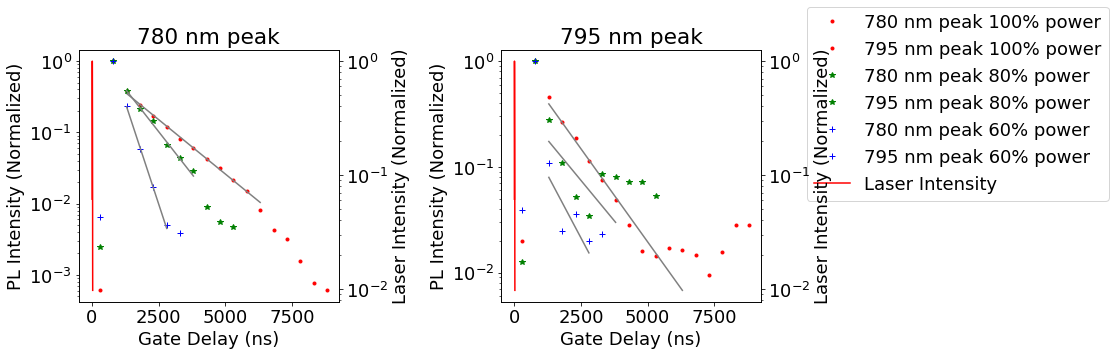

In [7]:
from matplotlib.ticker import ScalarFormatter


fig, ax1 = plt.subplots(1,2,figsize=(12,5))
ln1 = ax1[0].plot(data_50Hz['Time']['NDF00'], data_50Hz['Data_p1_max_norm']['NDF00'], 'r.', label = '780 nm peak 100% power')
ax1[0].plot(fits_50Hz['Fit_p1_time']['NDF00'], fits_50Hz['Fit_p1']['NDF00'], '-', color = 'grey', label = '780 nm peak 100% power')

ln2 = ax1[1].plot(data_50Hz['Time']['NDF00'], data_50Hz['Data_p2_max_norm']['NDF00'], 'r.', label = '795 nm peak 100% power')
ax1[1].plot(fits_50Hz['Fit_p2_time']['NDF00'], fits_50Hz['Fit_p2']['NDF00'], '-', color = 'grey', label = '780 nm peak 100% power')

ln3 = ax1[0].plot(data_50Hz['Time']['NDF01'], data_50Hz['Data_p1_max_norm']['NDF01'], 'g*', label = '780 nm peak 80% power')
ax1[0].plot(fits_50Hz['Fit_p1_time']['NDF01'], fits_50Hz['Fit_p1']['NDF01'], '-', color = 'grey', label = '780 nm peak 100% power')

ln4 = ax1[1].plot(data_50Hz['Time']['NDF01'], data_50Hz['Data_p2_max_norm']['NDF01'], 'g*', label = '795 nm peak 80% power')
ax1[1].plot(fits_50Hz['Fit_p2_time']['NDF01'], fits_50Hz['Fit_p2']['NDF01'], '-', color = 'grey', label = '780 nm peak 100% power')

ln5 = ax1[0].plot(data_50Hz['Time']['NDF02'], data_50Hz['Data_p1_max_norm']['NDF02'], 'b+', label = '780 nm peak 60% power')
ax1[0].plot(fits_50Hz['Fit_p1_time']['NDF02'], fits_50Hz['Fit_p1']['NDF02'], '-', color = 'grey', label = '780 nm peak 100% power')

ln6 = ax1[1].plot(data_50Hz['Time']['NDF02'], data_50Hz['Data_p2_max_norm']['NDF02'], 'b+', label = '795 nm peak 60% power')
ax1[1].plot(fits_50Hz['Fit_p2_time']['NDF02'], fits_50Hz['Fit_p2']['NDF02'], '-', color = 'grey', label = '780 nm peak 100% power')




#plt.title("Rubidium Vapor PL (50 Hz rep rate)", loc = 'top')

for ax in ax1:
    ax.set_xlabel("Gate Delay (ns)")
    # Make the y-axis label, ticks and tick labels match the line color.
    ax.set_ylabel("PL Intensity (Normalized)")
    ax.tick_params('y')
    ax.loglog
    #ax.set_aspect(5)
    ax2 = ax.twinx()
    ln7= ax2.plot(laser_time_off, laser_data_norm, 'r', label = 'Laser Intensity')
    ax2.set_ylabel("Laser Intensity (Normalized)")
    ax2.tick_params('y')
    ax2.set_yscale('log')
    ax.set_yscale('log')

    
ax1[0].set_title('780 nm peak')
ax1[1].set_title('795 nm peak')



fig.tight_layout()

lns = ln1+ln2+ln3+ln4+ln5+ln6+ln7
labs = [l.get_label() for l in lns]
ax1[0].legend(lns, labs, loc=(2.8,0.4))



#ax2.yaxis.set_major_formatter(ScalarFormatter())

plt.show()



Text(0,0.5,'Peak Intensity (counts)')

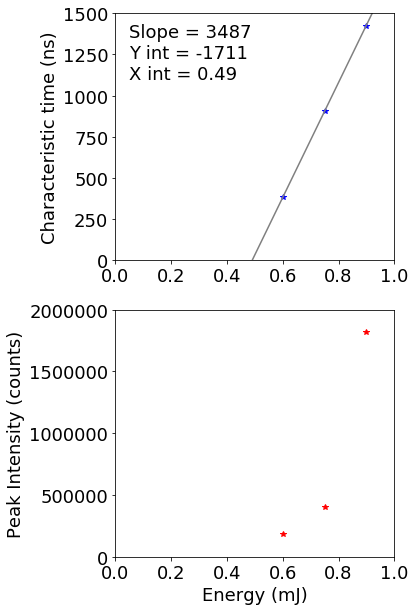

In [8]:
maximums = np.array([data_50Hz['Data_p1_max']['NDF00'].max(),data_50Hz['Data_p1_max']['NDF01'].max(),data_50Hz['Data_p1_max']['NDF02'].max()]) 

slopes = [-1/fits_50Hz['Fit_p1_param']['NDF00'][0],-1/fits_50Hz['Fit_p1_param']['NDF01'][0],-1/fits_50Hz['Fit_p1_param']['NDF02'][0]]

powers = [np.average(data_50Hz['Power_avg']['NDF00']),np.average(data_50Hz['Power_avg']['NDF01']),np.average(data_50Hz['Power_avg']['NDF02'])]
powers = np.array(powers)*1000



fit_char =np.polyfit(powers, slopes, 1)
fit_char_f =  np.poly1d(fit_char)

x_pow = np.linspace(0, 1, 100)


fig, ax = plt.subplots(2,1,figsize=(5,10))
ax[0].set_ylabel('Characteristic time (ns)')

ax[0].set_ylim([0,1500])
ax[0].set_xlim([0,1])
ax[0].plot(powers,slopes, 'b*')
ax[0].plot(x_pow, fit_char_f(x_pow), color = 'grey')

slopestr = "{:.{}f}".format( fit_char[0], 0 )
yintstr = "{:.{}f}".format( fit_char[1], 0 )
xintstr = "{:.{}f}".format(-fit_char[1]/fit_char[0], 2 )


ax[0].text(0.05,1100,'Slope = ' + slopestr + '\nY int = ' + yintstr + '\nX int = ' + xintstr)

ax[1].plot(powers, maximums,'r*')
#ax[1].set_yscale('log')
ax[1].set_xlabel('Energy (mJ)')
ax[1].set_xlim([0,1])
ax[1].set_ylim([0,2e6])
ax[1].set_ylabel('Peak Intensity (counts)')

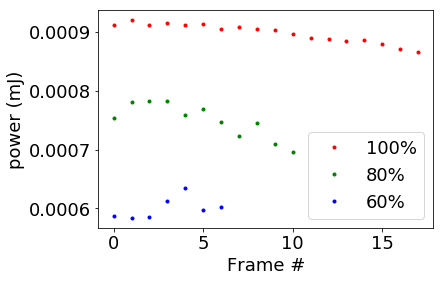

In [9]:
fig, ax1 = plt.subplots(1,1)

ln1 = ax1.plot(data_50Hz['Power_avg']['NDF00'], 'r.', label = '100%')
ln2 = ax1.plot(data_50Hz['Power_avg']['NDF01'], 'g.', label = '80%')
ln3 = ax1.plot(data_50Hz['Power_avg']['NDF02'], 'b.', label = '60%')

ax1.set_ylabel('power (mJ)')
ax1.set_xlabel('Frame #')
lns = ln1 + ln2 + ln3

labs = [l.get_label() for l in lns]
ax1.legend(lns, labs)
